# Analysis of optogenetic stimuli on top of drifting grating stimulus

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from bluepy import Cell, Synapse, Circuit, Simulation
import os
import json
from helper_functions import load_sim_results #, get_activity, plot_PSTH, get_single_cell_psths
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/4068aac5-4e36-4fb3-8ee8-5d612f13c2dd/analyses/simulations.pkl'
# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/1978b10b-1508-4584-a71a-2fb8a4809d7a/analyses/simulations.pkl'
sims = pd.read_pickle(sims_file)

save_path = os.path.join(os.path.split(sims_file)[0], 'visual_contrast_analysis')
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [4]:
# Load results into dataframes
blank_rates_table, stim_rates_table, opto_rates_table, blue_configs, stim_configs, opto_configs = load_sim_results(sims)

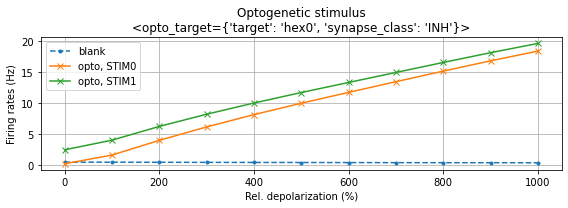

In [4]:
# Plot firing rates vs. depolarization
stim_ids = np.unique([int(str.replace(k[str.find(k, '_STIM'):], '_STIM', '')) for k in opto_rates_table.keys() if str.find(k, '_STIM') >= 0])

plt.figure(figsize=(8, 3))
depol = opto_rates_table.index.get_level_values('opto_depol_pct')
plt.plot(depol, blank_rates_table['FullTarget'], '.--', label=f'blank')
for s in stim_ids:
    plt.plot(depol, opto_rates_table[f'FullTarget_STIM{s}'], 'x-', label=f'opto, STIM{s}')
plt.xlabel('Rel. depolarization (%)')
plt.ylabel('Firing rates (Hz)')
plt.legend()
plt.grid()
plt.title(f'Optogenetic stimulus\n<opto_target={opto_configs[-1]["cfg"]["opto_target"]}>')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'firing_rates_vs_depol.png'), dpi=300)
plt.show()

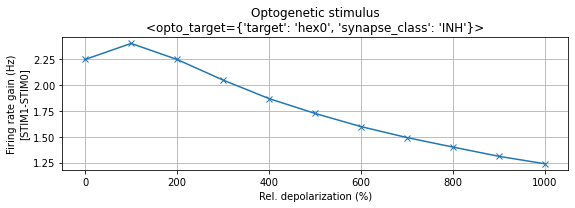

In [11]:
# Plot firing rate gain vs. depolarization
plt.figure(figsize=(8, 3))
plt.plot(depol, opto_rates_table['FullTarget_STIM1'] - opto_rates_table['FullTarget_STIM0'], 'x-')
plt.xlabel('Rel. depolarization (%)')
plt.ylabel('Firing rate gain (Hz)\n[STIM1-STIM0]')
plt.grid()
plt.title(f'Optogenetic stimulus\n<opto_target={opto_configs[-1]["cfg"]["opto_target"]}>')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'firing_rate_gain_vs_depol.png'), dpi=300)
plt.show()

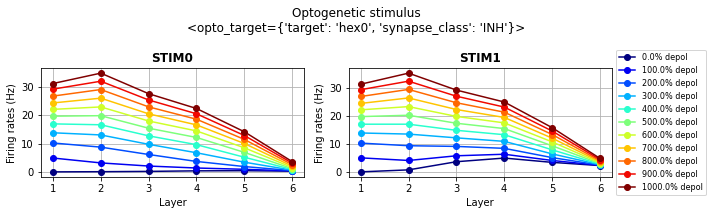

In [12]:
# Plot firing rates vs. injection target layers
num_layers = 6
layer_targets = [f'FullTargetL{lidx + 1}' for lidx in range(num_layers)]
sim_colors = plt.cm.jet(np.linspace(0, 1, sims.shape[0]))
plt.figure(figsize=(10, 3))
for s in stim_ids:
    plt.subplot(1, len(stim_ids), s + 1)
    for sidx in range(sims.shape[0]):
        plt.plot(np.arange(1, num_layers + 1), opto_rates_table.iloc[sidx][[lay + f'_STIM{s}' for lay in layer_targets]], 'o-', color=sim_colors[sidx, :], label=f'{depol[sidx]}% depol')
    plt.xlabel('Layer')
    plt.ylabel('Firing rates (Hz)')
    plt.title(f'STIM{s}', fontweight='bold')
    plt.grid()
plt.legend(loc='center left', fontsize=8, bbox_to_anchor=[1.0, 0.5])
plt.suptitle(f'Optogenetic stimulus\n<opto_target={opto_configs[-1]["cfg"]["opto_target"]}>')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'firing_rates_vs_layers.png'), dpi=300)
plt.show()

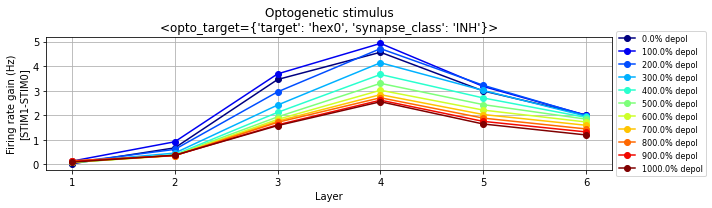

In [13]:
# Plot firing rate gain vs. injection target layers
plt.figure(figsize=(10, 3))
for sidx in range(sims.shape[0]):
    plt.plot(np.arange(1, num_layers + 1), opto_rates_table.iloc[sidx][[lay + '_STIM1' for lay in layer_targets]].to_numpy() - opto_rates_table.iloc[sidx][[lay + '_STIM0' for lay in layer_targets]].to_numpy(), 'o-', color=sim_colors[sidx, :], label=f'{depol[sidx]}% depol')
plt.xlabel('Layer')
plt.ylabel('Firing rate gain (Hz)\n[STIM1-STIM0]')
plt.grid()
plt.legend(loc='center left', fontsize=8, bbox_to_anchor=[1.0, 0.5])
plt.title(f'Optogenetic stimulus\n<opto_target={opto_configs[-1]["cfg"]["opto_target"]}>')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'firing_rate_gain_vs_layers.png'), dpi=300)
plt.show()

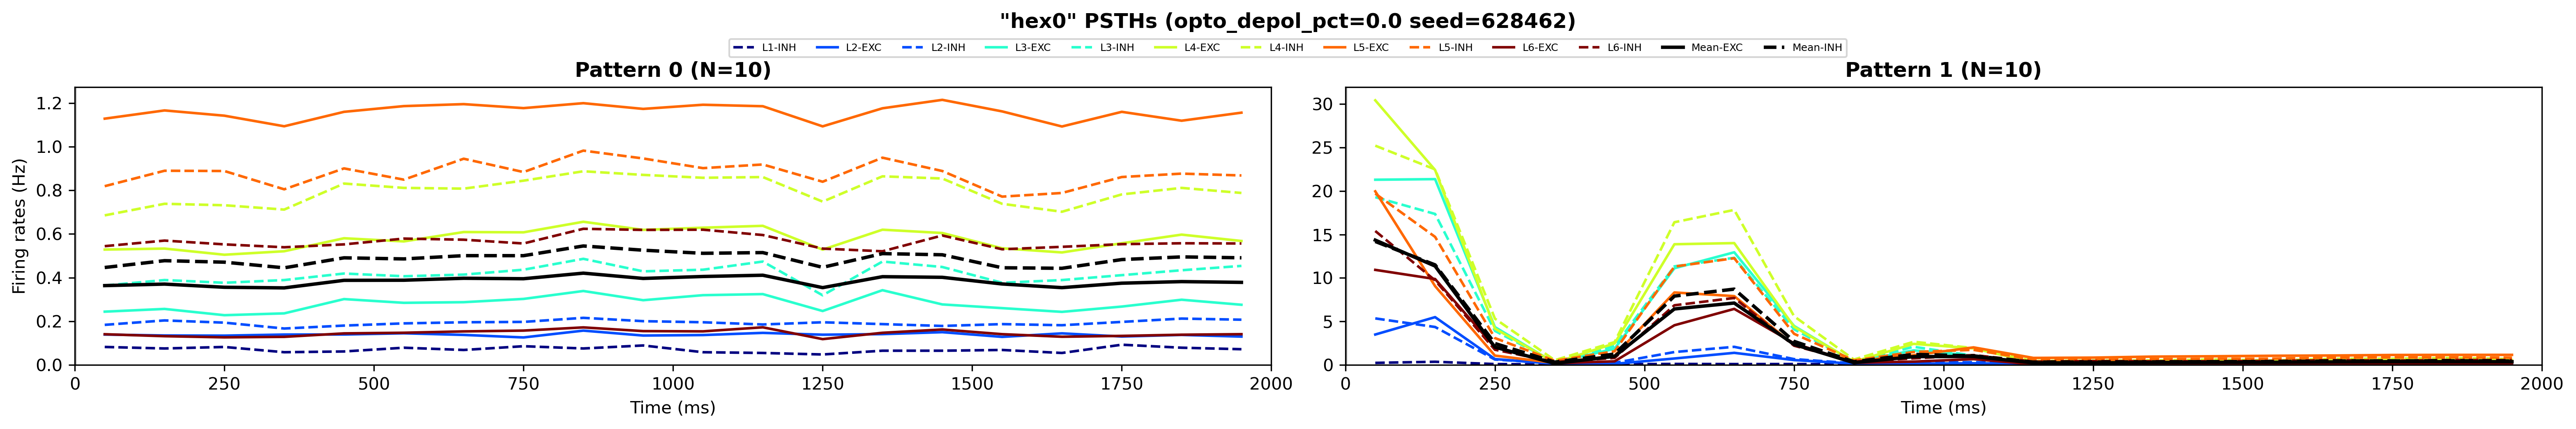

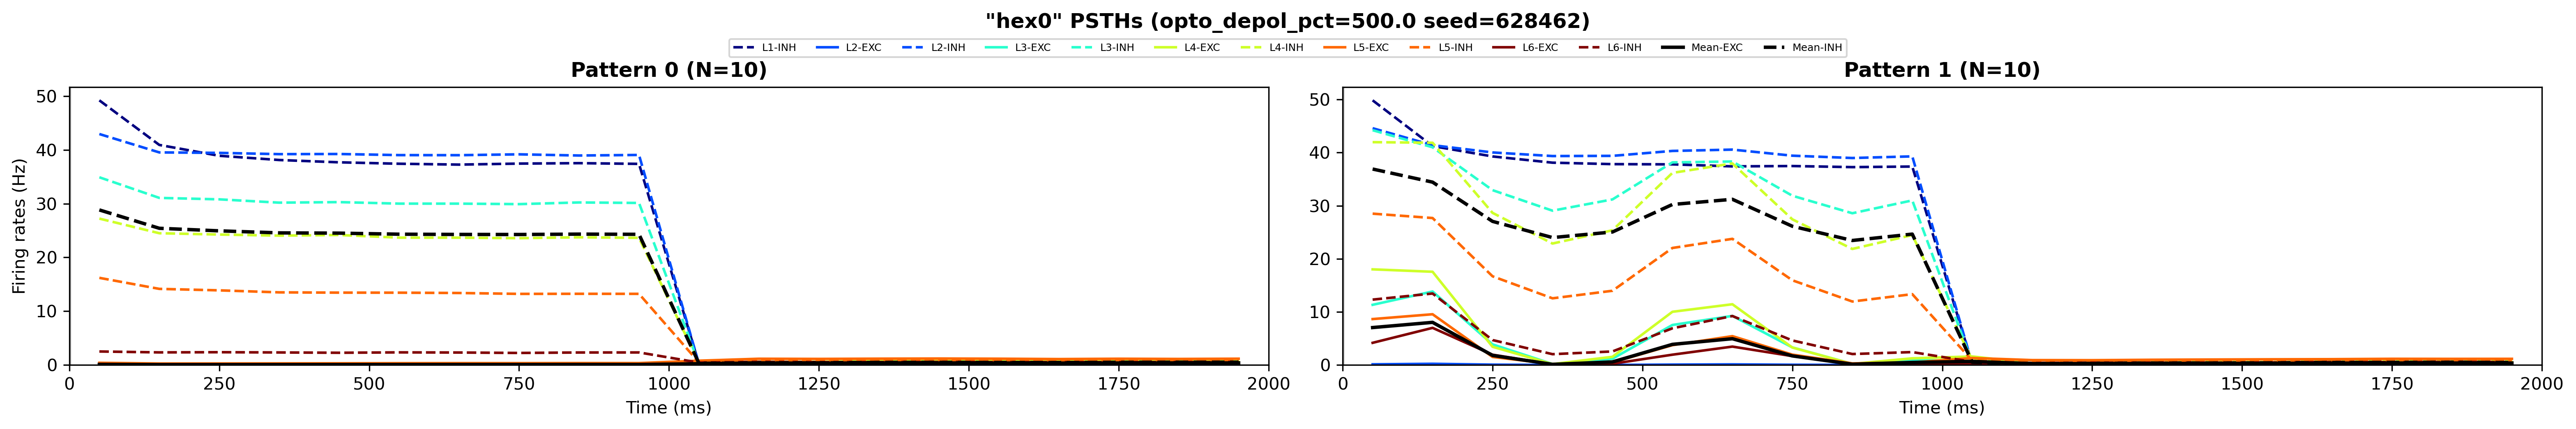

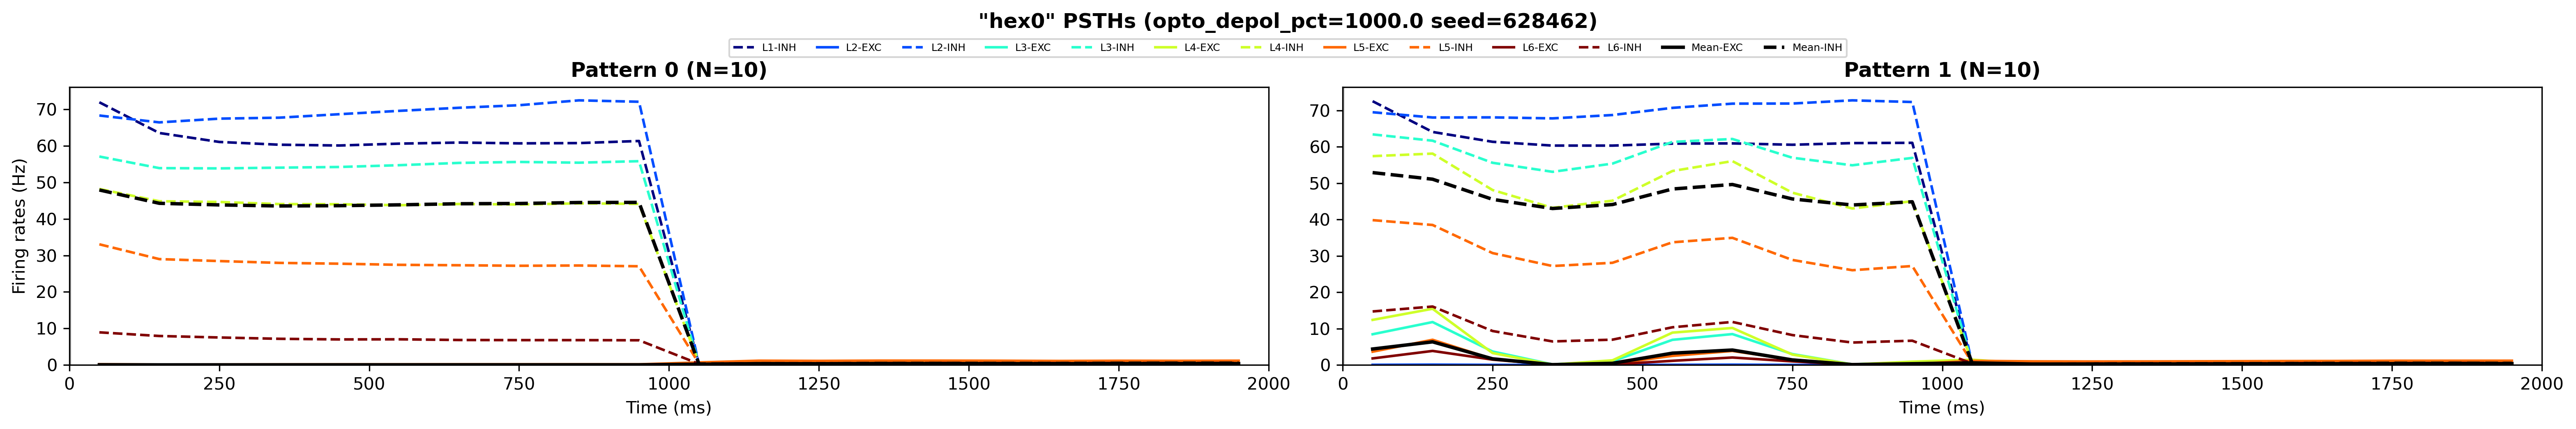

In [14]:
for idx in [0, 5, 10]:
    blue_config = sims.iloc[idx]
    plot_PSTH(blue_config, psth_bin_size=100, psth_interval=None, psth_target='hex0', label=' '.join([f'{i[0]}={i[1]}' for i in zip(sims.index.names, sims.index[idx])]), match_scale=False, save_fn=os.path.join(save_path, f'psth_{idx}.png'))

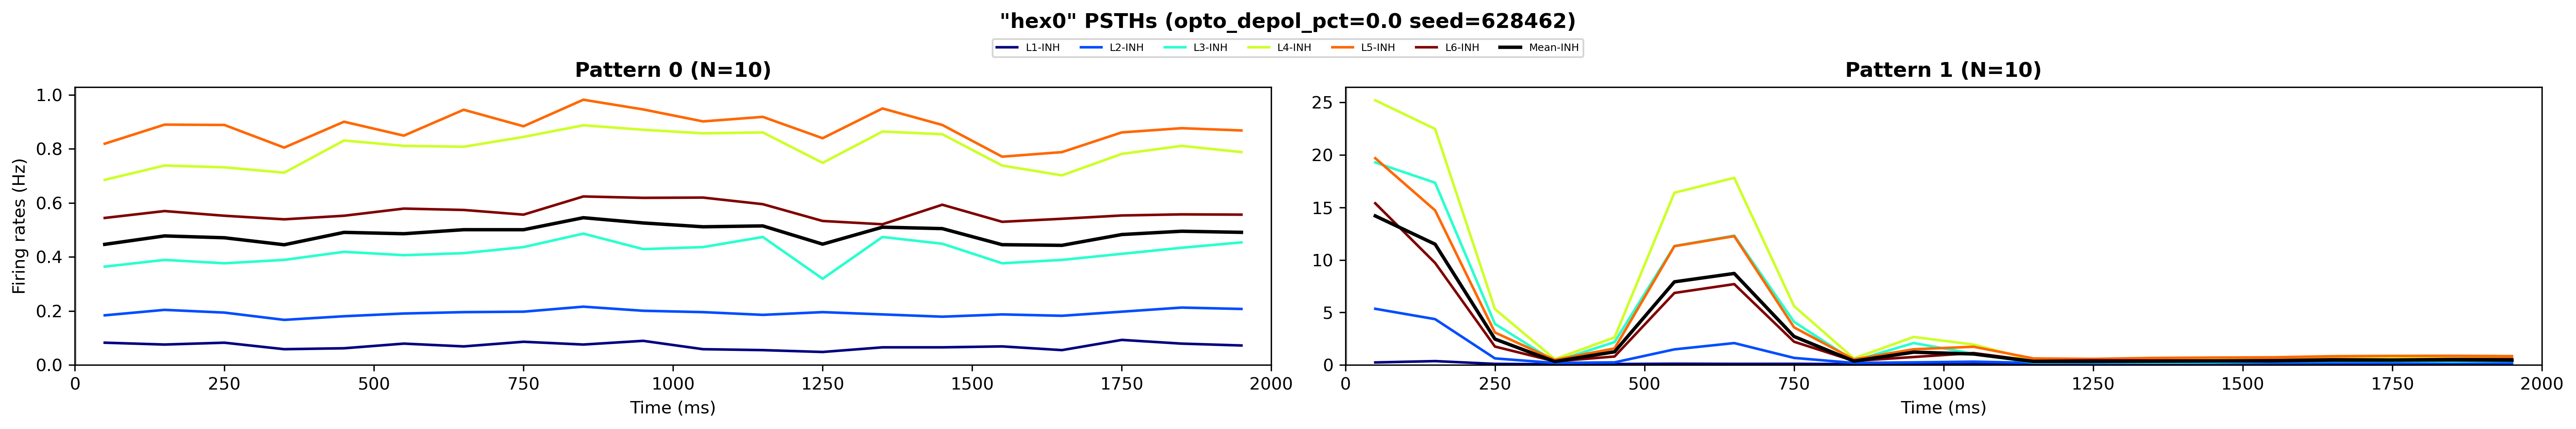

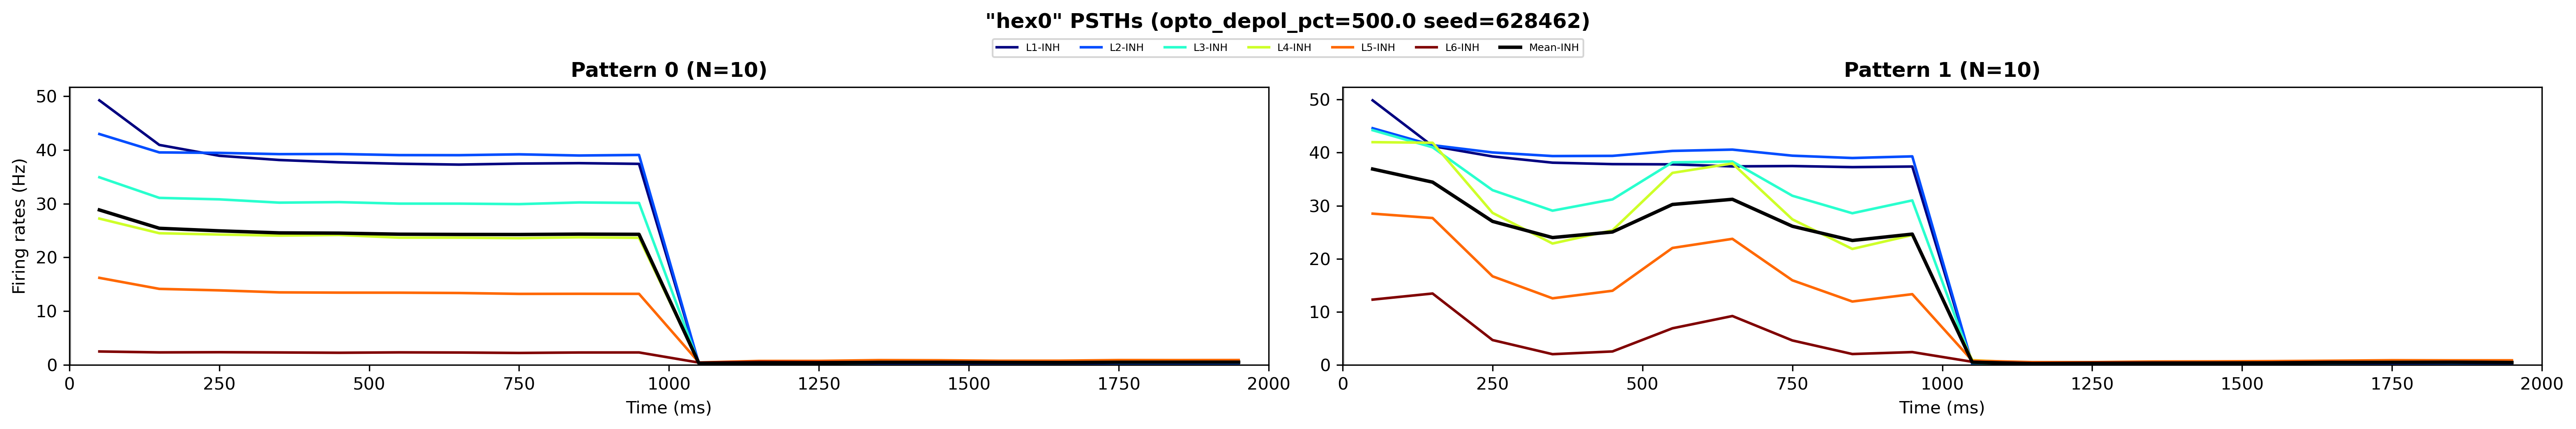

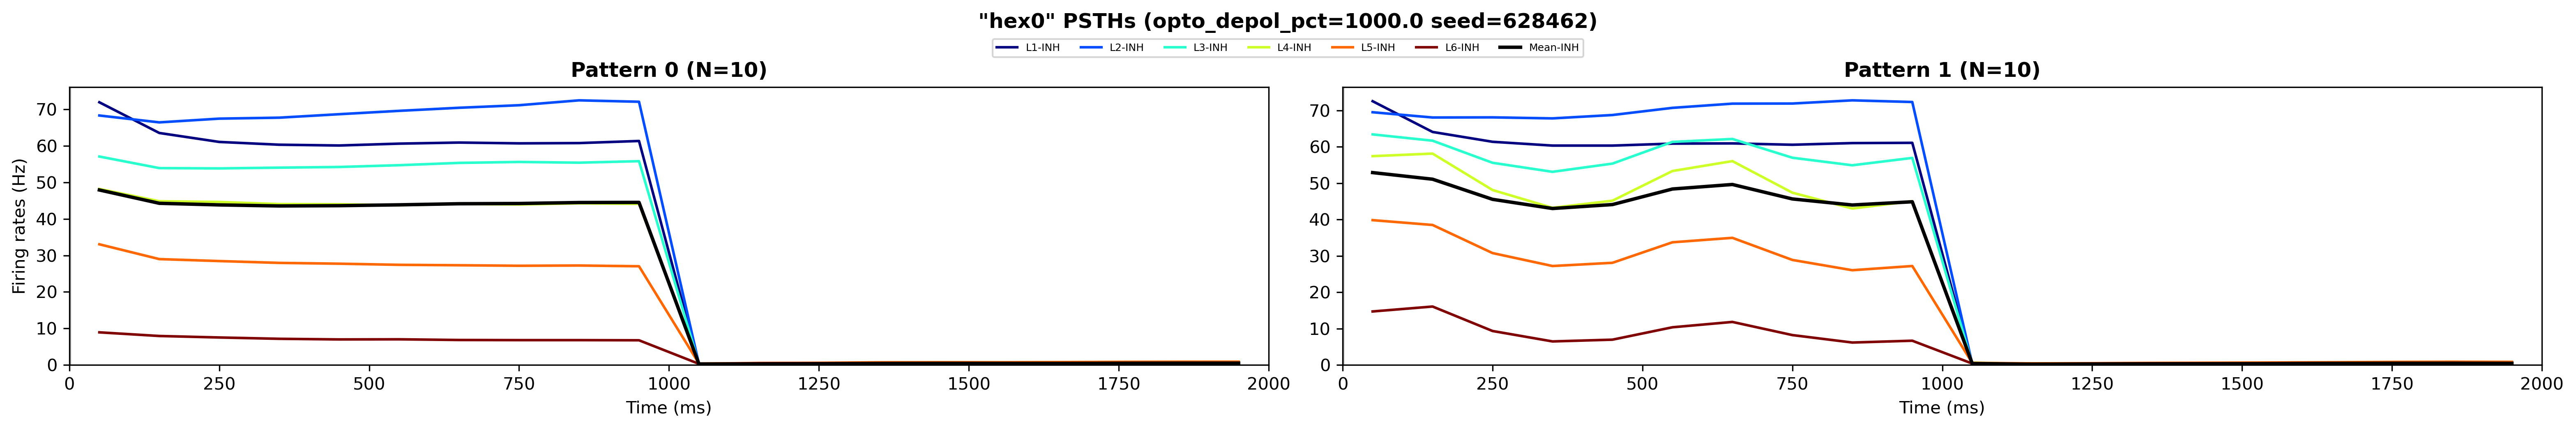

In [15]:
for idx in [0, 5, 10]:
    blue_config = sims.iloc[idx]
    plot_PSTH(blue_config, psth_bin_size=100, psth_interval=None, psth_target='hex0', syn_classes=['INH'], label=' '.join([f'{i[0]}={i[1]}' for i in zip(sims.index.names, sims.index[idx])]), match_scale=False, save_fn=os.path.join(save_path, f'psth_INH_{idx}.png'))

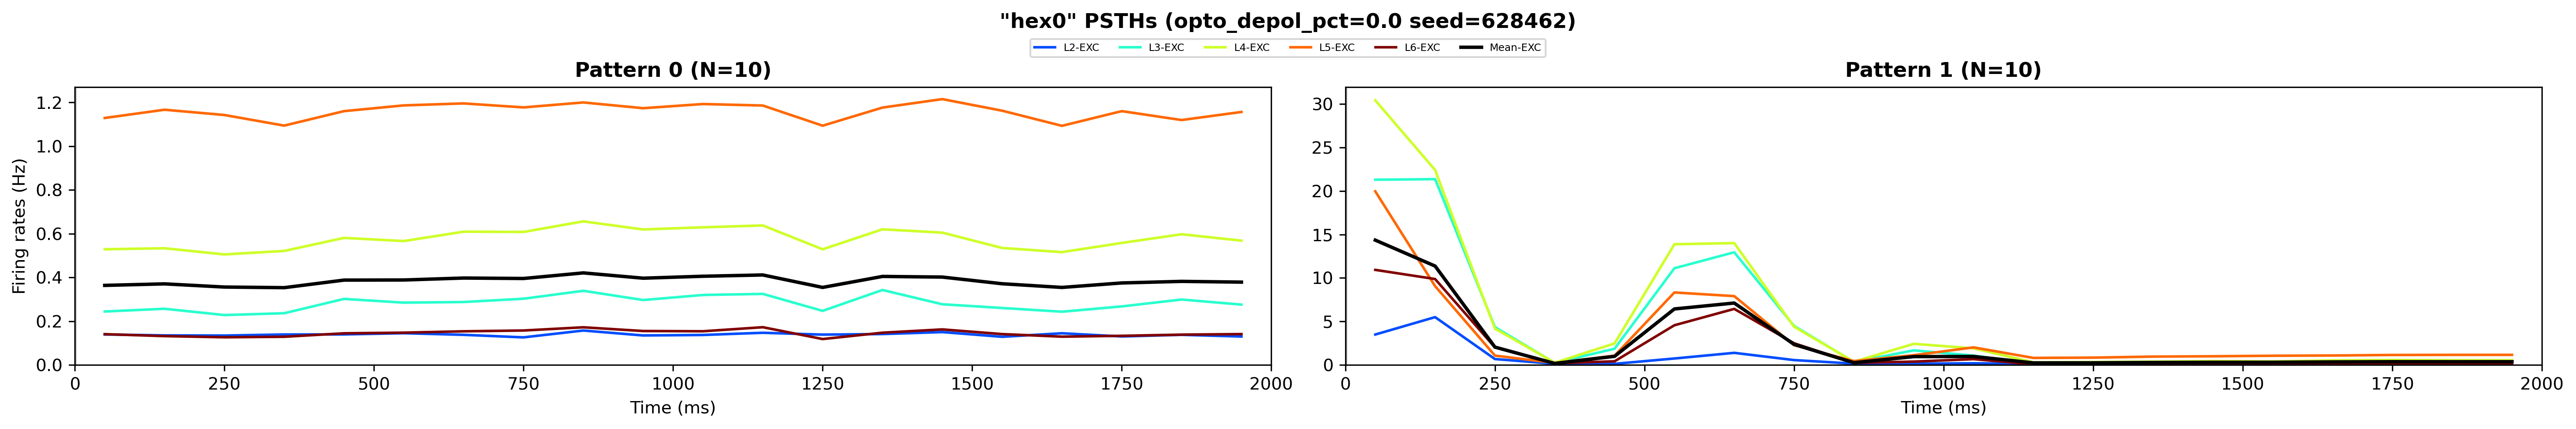

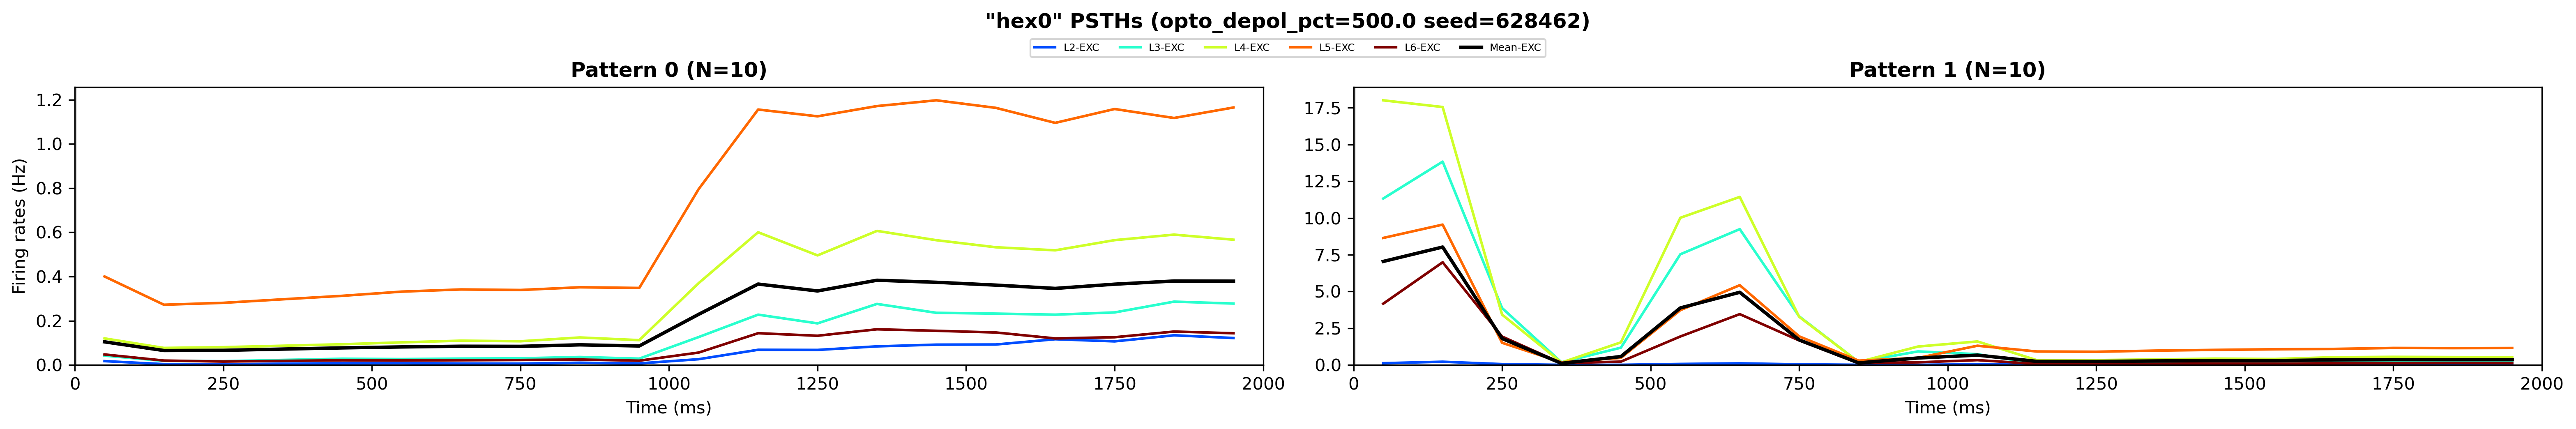

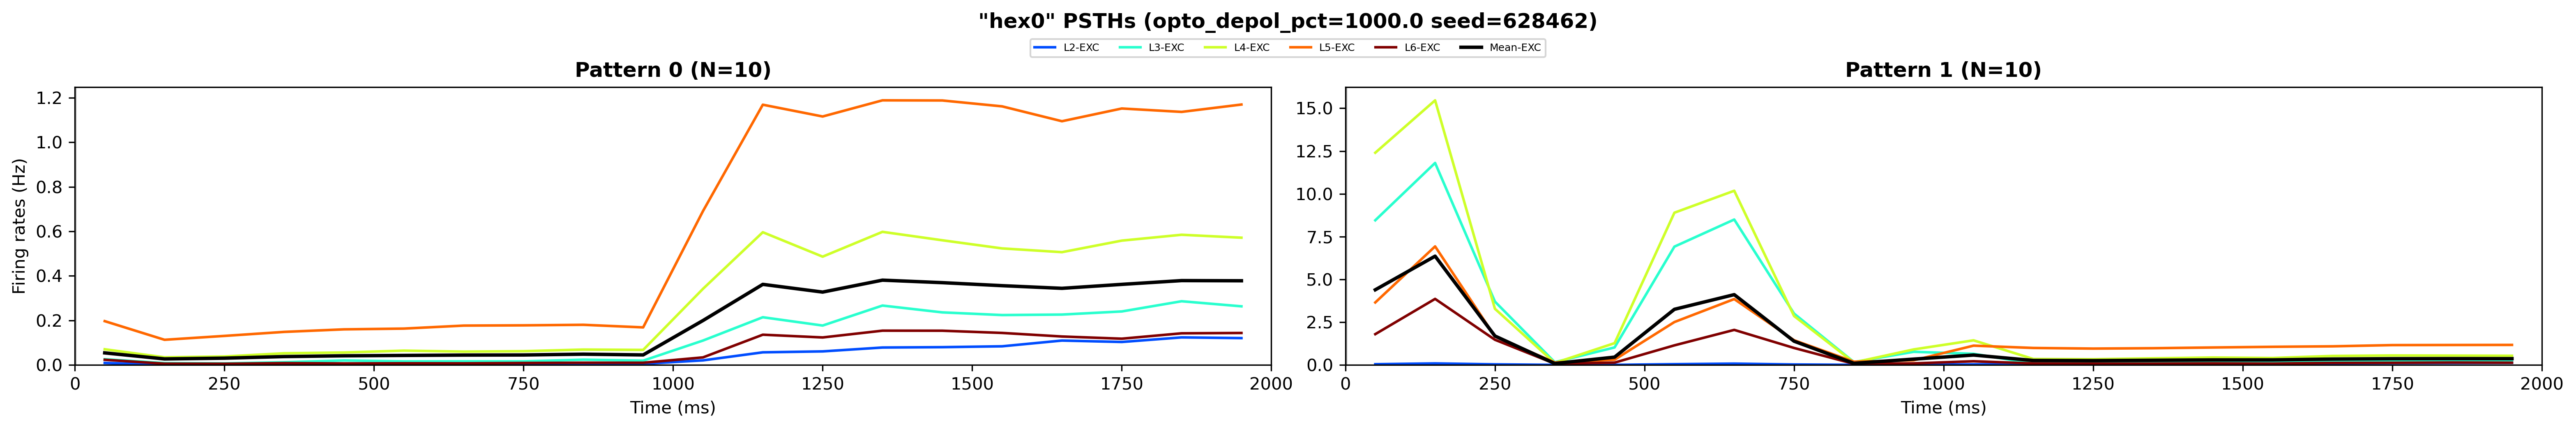

In [16]:
for idx in [0, 5, 10]:
    blue_config = sims.iloc[idx]
    plot_PSTH(blue_config, psth_bin_size=100, psth_interval=None, psth_target='hex0', syn_classes=['EXC'], label=' '.join([f'{i[0]}={i[1]}' for i in zip(sims.index.names, sims.index[idx])]), match_scale=False, save_fn=os.path.join(save_path, f'psth_EXC_{idx}.png'))

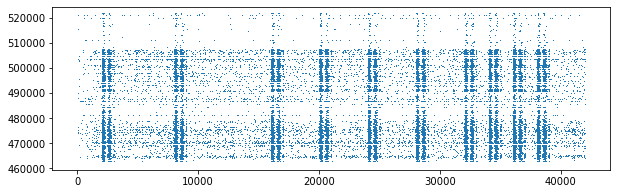

In [17]:
# Spike train visualization (example)
sim = Simulation(sims.iloc[0])
c = sim.circuit
gids = c.cells.ids('hex0')
gids = np.intersect1d(gids, c.cells.ids({'layer': 3, 'synapse_class': 'INH'}))
spikes = sim.spikes.get(gids)
plt.figure(figsize=(10, 3))
plt.plot(spikes.index, spikes.values, ',')
plt.show()

In [35]:
# Single-cell PSTHs
cell_sel = {'synapse_class': 'INH', 'layer': 4}
sel_spec = '_'.join([f'{k}{v}' for k, v in cell_sel.items()])
sel_spec = sel_spec.replace('synapse_class', '')
sel_spec = sel_spec.replace('layer', 'L')
t_rate, rates, spike_trains, avg_cell_rates, stim_cfg, opto_cfg = get_single_cell_psths(sims.iloc[0], {'target': 'hex0', **cell_sel}, t_res=1.0, t_smooth=20.0)

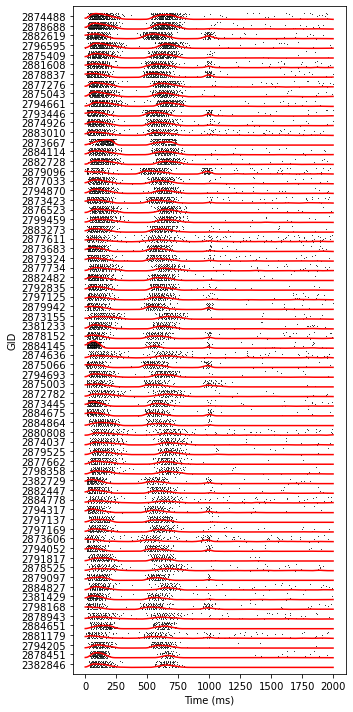

In [36]:
patt_sel = 3 # N patterns: 0..N-1 w/o opto, N..2N-1 with opto
rate_sel = (10.0, np.inf)
y_scale = 0.075

# Filter & sort GIDs by increasing firing rates
gids = np.array(list(spike_trains[patt_sel].keys()))
avg_rates_sel = np.array(avg_cell_rates[patt_sel])
rates_sel = rates[patt_sel]
sort_idx = np.argsort(avg_rates_sel)
gids = gids[sort_idx]
avg_rates_sel = avg_rates_sel[sort_idx]
rates_sel = rates_sel[sort_idx, :]
sel_idx = np.logical_and(avg_rates_sel > rate_sel[0], avg_rates_sel < rate_sel[-1])
gids = gids[sel_idx] # Filter gids based on firing rates
rates_sel = rates_sel[sel_idx, :]

plt.figure(figsize=(5, 10))
for gidx, gid in enumerate(gids):
    trials = spike_trains[patt_sel][gid]
    for trial, st in enumerate(trials):
        plt.plot(st, np.full(len(st), (trial - 0.5 * (len(trials) - 1)) * y_scale + gidx), '.k', markersize=2.0, markeredgecolor='none')
    plt.plot(t_rate, gidx - y_scale * 0.5 * (len(trials) - 1) + y_scale * len(trials) * rates_sel[gidx, :] / np.max(rates_sel), 'r-')
plt.yticks(np.arange(len(gids)), gids)
plt.ylim((-1, len(gids)))
plt.xlabel('Time (ms)')
plt.ylabel('GID')
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'psth_spikes_{sel_spec}.png'), dpi=300)
plt.show()

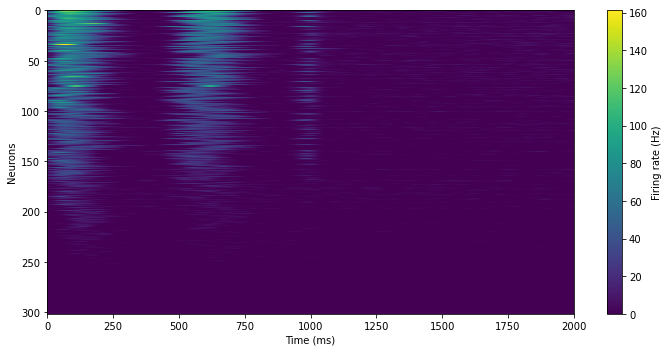

In [37]:
# Plot instantaneous firing rates (overview map)
plt.figure(figsize=(10, 5))
t_res = np.median(np.diff(t_rate))
plt.imshow(rates[patt_sel][np.flip(sort_idx), :], extent=(t_rate[0] - 0.5 * t_res, t_rate[-1] + 0.5 * t_res, rates[patt_sel].shape[0] - 0.5, -0.5), aspect='auto', interpolation='nearest')
plt.colorbar(label='Firing rate (Hz)')
plt.xlabel('Time (ms)')
plt.ylabel('Neurons')
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'psth_rates_{sel_spec}.png'), dpi=300)
plt.show()

In [38]:
# Peak detection (first & second peak)
from scipy.signal import find_peaks
peak_th = 20.0 # (Hz)
peak_width = 20.0 # (ms)
peak_idx = [find_peaks(r, height=peak_th, width=peak_width / t_res)[0] for r in rates_sel]
peak_t = [t_rate[pidx] for pidx in peak_idx]
peak_rate = [rates_sel[idx][pidx] for idx, pidx in enumerate(peak_idx)]
t1 = [t[0] for t in peak_t] # First peak time
t2 = [t[1] for t in peak_t] # Second peak time
r1 = [r[0] for r in peak_rate] # First peak rate
r2 = [r[1] for r in peak_rate] # Second peak rate
peak_ratio = np.array([(_r1 - _r2) / (_r1 + _r2) for (_r1, _r2) in zip(r1, r2)])

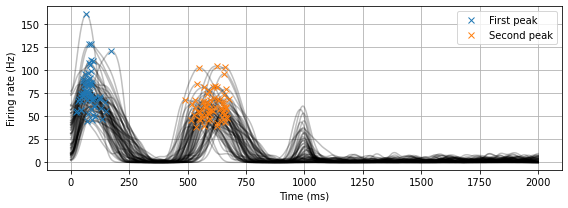

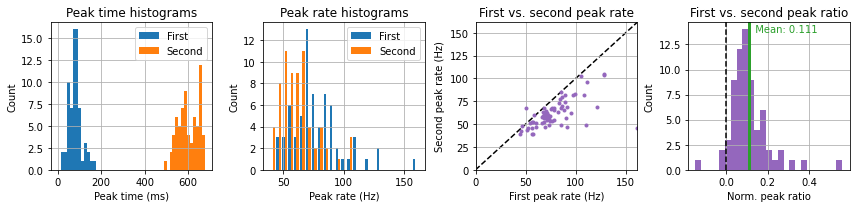

In [39]:
# Plot instantaneous firing rates inkl. peaks (selected GIDs)
plt.figure(figsize=(8, 3))
plt.plot(t_rate, rates_sel.T, 'k', alpha=0.25)
for idx in range(len(peak_idx)):
    plt.plot(t1[idx], r1[idx], 'x', color='tab:blue', alpha=1.0, label='First peak' if idx == 0 else None)
    plt.plot(t2[idx], r2[idx], 'x', color='tab:orange', alpha=1.0, label='Second peak' if idx == 0 else None)
plt.grid()
plt.xlabel('Time (ms)')
plt.ylabel('Firing rate (Hz)')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'psth_rate_peaks_{sel_spec}.png'), dpi=300)
plt.show()

# Plot first vs. second peak
plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
num_bins = 50
plt.hist(t1, bins=np.linspace(0, np.max([t1, t2]), num_bins + 1), width=1.0 * np.max([t1, t2]) / num_bins, label='First')
plt.hist(t2, bins=np.linspace(0, np.max([t1, t2]), num_bins + 1), width=1.0 * np.max([t1, t2]) / num_bins, label='Second')
plt.grid()
plt.xlabel('Peak time (ms)')
plt.ylabel('Count')
plt.title('Peak time histograms')
plt.legend()

plt.subplot(1, 4, 2)
num_bins = 25
plt.hist([r1, r2], bins=num_bins, label=['First', 'Second'])
plt.grid()
plt.xlabel('Peak rate (Hz)')
plt.ylabel('Count')
plt.title('Peak rate histograms')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(r1, r2, '.', color='tab:purple')
plt.xlim([0, max(max(r1), max(r2))])
plt.ylim([0, max(max(r1), max(r2))])
plt.plot([min(plt.xlim()), max(plt.xlim())], [min(plt.ylim()), max(plt.ylim())], '--k', zorder=0)
plt.grid()
plt.xlabel('First peak rate (Hz)')
plt.ylabel('Second peak rate (Hz)')
plt.title('First vs. second peak rate')

plt.subplot(1, 4, 4)
num_bins = 25
plt.hist(peak_ratio, bins=num_bins, color='tab:purple')
plt.ylim(plt.ylim())
plt.plot(np.zeros(2), plt.ylim(), '--k')
plt.plot(np.full(2, np.mean(peak_ratio)), plt.ylim(), '-', color='tab:green', linewidth=3)
plt.text(np.mean(peak_ratio), 0.99 * max(plt.ylim()), f'  Mean: {np.mean(peak_ratio):.3f}', color='tab:green', ha='left', va='top')
plt.grid()
plt.xlabel('Norm. peak ratio')
plt.ylabel('Count')
plt.title('First vs. second peak ratio')

plt.tight_layout()
plt.savefig(os.path.join(save_path, f'psth_peak_stats_{sel_spec}.png'), dpi=300)
plt.show()

In [ ]:
# TODO => Grating + opto stimulus:
# * Single cell activity
#   - Average rates over opto/blank intervals
#   - Instantaneous rates over opto/blank intervals
#   - Peak rates at first/second grating cycle (in case of grating stimulus)